# Sentiment Analysis on Mobile Banking reviews

The given task is to learn sentiment from all the given reviews and predict rating from a new review. This objective is attained by following the steps listed below:

### Importing the modules

In [2]:
import pandas as pd
import numpy as np
import nltk
import future
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from bs4 import BeautifulSoup  
import re
import nltk
from nltk.corpus import stopwords 

In [40]:
col_names = ["sentiment", "review"]

data = pd.read_csv('Amazon_Unlocked_Mobile.csv',names=col_names,error_bad_lines=False)
print(data.head())

        sentiment                                             review
id      sentiment                                             review
5814_8          1  With all this stuff going down at the moment w...
2381_9          1  \"The Classic War of the Worlds\" by Timothy H...
7759_3          0  The film starts with a manager (Nicholas Bell)...
3630_4          0  It must be assumed that those who praised this...


In [41]:
print(data.head())

        sentiment                                             review
id      sentiment                                             review
5814_8          1  With all this stuff going down at the moment w...
2381_9          1  \"The Classic War of the Worlds\" by Timothy H...
7759_3          0  The film starts with a manager (Nicholas Bell)...
3630_4          0  It must be assumed that those who praised this...


### Data Labeling

- In this step we clean the data and label the data as <br>
  > 0 for Poor <br>
  > 1 for Neutral <br>
  > 2 for Good
- Read the data from __'Amazon_Unlocked_Mobile.csv'__ and add new column for labels

In [42]:
def label_data():
      col_names = ["sentiment", "review"]
      data = pd.read_csv('Amazon_Unlocked_Mobile.csv',names=col_names,error_bad_lines=False)    
#     labels = []
#     for cell in rows['sentiment']:
#         if cell == 1:
#             labels.append('1')   #Good
#         else:
#             labels.append('0')   #Poor
            
#     rows['label'] = labels
#     del rows['review']
#     return rows
print(data.head())

        sentiment                                             review
id      sentiment                                             review
5814_8          1  With all this stuff going down at the moment w...
2381_9          1  \"The Classic War of the Worlds\" by Timothy H...
7759_3          0  The film starts with a manager (Nicholas Bell)...
3630_4          0  It must be assumed that those who praised this...


### Data Cleaning

Remove all the rows containing blank cells. The resultant data is stored as __'labelled_dataset.csv'__

In [43]:
def clean_data(data):
    #columnwise print number of rows containing blank values
    #print data.isnull().sum()
    
    #replace blank values in all the cells with 'nan'
    data.replace('',np.nan,inplace=True)
    #delete all the rows which contain at least one cell with nan value
    data.dropna(axis=0, how='any', inplace=True)
    
    #Check the number of rows containing blank values. This should be zero now as compared to first line of this function
    #print data.isnull().sum()
    #save output csv file
    data.to_csv('labelled_dataset.csv', index=False)
    return data

With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally star

### Data preprocessing

The following text preprocessing are implemented to convert raw reviews to cleaned review, so that it will be easier for us to do feature extraction in the next step.

- remove html tags using BeautifulSoup
- remove non-character such as digits and symbols
- convert to lower case
- remove stop words such as "the" and "and" if needed
- convert to root words by stemming if needed

In [44]:
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False):
    '''
    Convert a raw review to a cleaned review
    '''
    text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
    letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True: # stemming
#         stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words))

In [45]:
def modelEvaluation(predictions, y_test_set):
    #Print model evaluation to predicted result 
    
#     print "\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test_set, predictions))
    print ("\nAccuracy on validation set: % 5.2f " %(accuracy_score(y_test_set, predictions)))
    #print "\nAUC score : {:.4f}".format(roc_auc_score(y_test_set, predictions))
    print ("\nClassification report : \n", metrics.classification_report(y_test_set, predictions))
    print ("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test_set, predictions))

### Bag of Words

The sentiment analysis of given text can be done in two ways. First, we need to find a word embedding to convert a text into a numerical representation. Second, we fit the numerical representations of text to machine learning algorithms or deep learning architectures.

One common approach of word embedding is frequency based embedding such as Bag of Words (BoW) model. BoW model learns a vocubulary list from a given corpus and represents each document based on some counting methods of words. In this part, we will explore the model performance of using BoW with supervised learning algorithms. Here's the workflow in this part.

- Step 1 : Preprocess raw reviews to cleaned reviews
- Step 2 : Create BoW using CountVectorizer / Tfidfvectorizer in sklearn
- Step 3 : Transform review text to numerical representations (feature vectors)
- Step 4 : Fit feature vectors to supervised learning algorithm (eg. Naive Bayes, Logistic regression, etc.)
- Step 5 : Improve the model performance by GridSearch

In [46]:
if __name__ == '__main__':
#     data = label_data()
    data = clean_data(data)
    #prints first 5 rows of the dataset
    print(data.head())    

        sentiment                                             review
id      sentiment                                             review
5814_8          1  With all this stuff going down at the moment w...
2381_9          1  \"The Classic War of the Worlds\" by Timothy H...
7759_3          0  The film starts with a manager (Nicholas Bell)...
3630_4          0  It must be assumed that those who praised this...


### Visualisation

Text(0, 0.5, 'Count')

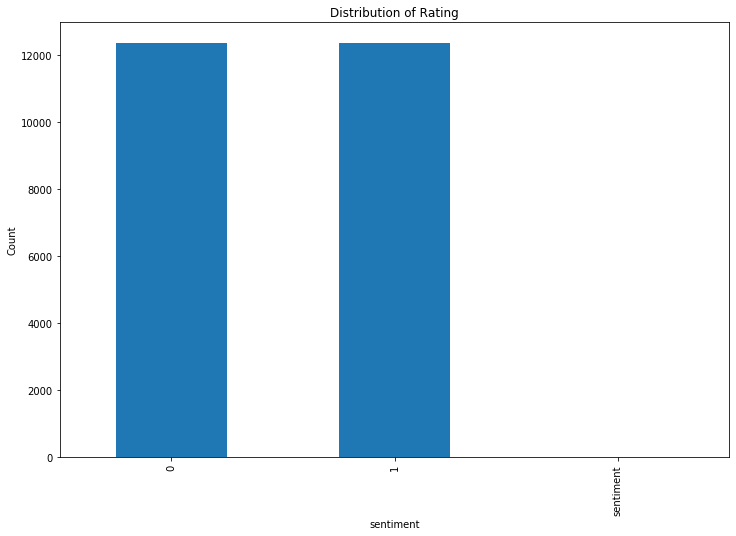

In [48]:
    # Plot distribution of rating
    plt.figure(figsize=(12,8))
    # sns.countplot(data['Rating'])
    data['sentiment'].value_counts().sort_index().plot(kind='bar')
    plt.title('Distribution of Rating')
    plt.xlabel('sentiment')
    plt.ylabel('Count')

In [49]:
    # Plot number of reviews for top 20 brands
    brands = data["Brand Name"].value_counts()
    # brands.count()
    plt.figure(figsize=(12,8))
    brands[:20].plot(kind='bar')
    plt.title("Number of Reviews for Top 20 Brands")

KeyError: 'Brand Name'

In [50]:
    # Plot number of reviews for top 50 products
    products = data["Product Name"].value_counts()
    plt.figure(figsize=(12,8))
    products[:50].plot(kind='bar')
    plt.title("Number of Reviews for Top 50 Products")

KeyError: 'Product Name'

Text(0, 0.5, 'Count')

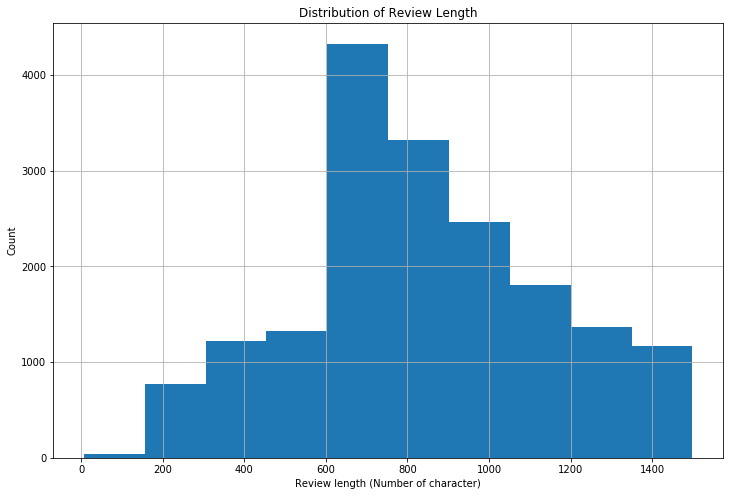

In [51]:
    # Plot distribution of review length
    review_length = data["review"].dropna().map(lambda x: len(x))
    plt.figure(figsize=(12,8))
    review_length.loc[review_length < 1500].hist()
    plt.title("Distribution of Review Length")
    plt.xlabel('Review length (Number of character)')
    plt.ylabel('Count')

In [52]:
    #split data into training and testing set
    x_train, x_test, y_train, y_test = train_test_split(data['review'], data['sentiment'], test_size=0.1, random_state=0)
    
    
    #If the label are words instead of numbers, they can be replaced programmatically using following two lines
    #y_train = label_binarize(y_train, classes=[0, 1, 2])
    #y_test = label_binarize(y_test, classes=[0, 1, 2])

In [53]:
    # Preprocess text data in training set and validation set
    x_train_cleaned = []
    x_test_cleaned = []

    for d in x_train:
        x_train_cleaned.append(cleanText(d))

    for d in x_test:
        x_test_cleaned.append(cleanText(d))    

### CountVectorizer with Mulinomial Naive Bayes (Benchmark Model)

Now we have cleaned reviews, the next step is to convert the reviews into numerical representations for machine learning algorithm.

In sklearn library, we can use CountVectorizer which implements both tokenization and occurrence counting in a single class. The output is a sparse matrix representation of a document.

In [61]:
    # Fit and transform the training data to a document-term matrix using CountVectorizer
    countVect = CountVectorizer() 
    x_train_countVect = countVect.fit_transform(x_train_cleaned)
    print ("Number of features : %d \n" %len(countVect.get_feature_names())) #6378 
    print ("Show some feature names : \n", countVect.get_feature_names()[::1000])

Number of features : 70748 

Show some feature names : 
 ['aa', 'afro', 'amulet', 'arirang', 'avuncular', 'batzella', 'bikers', 'bono', 'brushing', 'cannibalism', 'chales', 'cinnamon', 'commemorate', 'controversial', 'croc', 'dazzy', 'descendent', 'disdains', 'dowling', 'eder', 'enlists', 'excoriated', 'favours', 'flics', 'friedkin', 'genious', 'gorgs', 'guttenburg', 'heard', 'holders', 'hyser', 'indra', 'invincibly', 'johnnys', 'kidnapping', 'lambrakis', 'libyan', 'ltas', 'manifestations', 'mcphee', 'mimi', 'mori', 'narrated', 'nopd', 'oom', 'paganistic', 'pendanski', 'pistoleers', 'powerglove', 'protoplasm', 'railroaded', 'reenacting', 'restructuring', 'ronins', 'santas', 'seaver', 'shepperd', 'skeptical', 'somberness', 'srbljanovic', 'striped', 'susbtituted', 'teahupoo', 'thugs', 'tranquillo', 'typist', 'unmanaged', 'vcrs', 'wakeup', 'wideboy', 'yah']


In [62]:
    # Train MultinomialNB classifier
    mnb = MultinomialNB()
    mnb.fit(x_train_countVect, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [63]:
    # Evaluate the model on validaton set
    predictions = mnb.predict(countVect.transform(x_test_cleaned))
    modelEvaluation(predictions, y_test)


Accuracy on validation set:  0.86 

Classification report : 
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1264
           1       0.88      0.83      0.86      1209

    accuracy                           0.86      2473
   macro avg       0.86      0.86      0.86      2473
weighted avg       0.86      0.86      0.86      2473


Confusion Matrix : 
 [[1122  142]
 [ 200 1009]]


### TfidfVectorizer with Logistic Regression

Some words might frequently appear but have little meaningful information about the sentiment of a particular review. Instead of using occurance counting, we can use tf-idf transform to scale down the impact of frequently appeared words in a given corpus.

In sklearn library, we can use TfidfVectorizer which implements both tokenization and tf-idf weighted counting in a single class.

In [65]:
    # Fit and transform the training data to a document-term matrix using TfidfVectorizer 
    tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
    x_train_tfidf = tfidf.fit_transform(x_train)
    print ("Number of features : %d \n" %len(tfidf.get_feature_names())) #1722
    print ("Show some feature names : \n", tfidf.get_feature_names()[::1000])

    # Logistic Regression
    lr = LogisticRegression()
    lr.fit(x_train_tfidf, y_train)

Number of features : 25778 

Show some feature names : 
 ['00', 'ambitions', 'barbra', 'bresson', 'cheryl', 'consumerism', 'deeply', 'download', 'ethan', 'flows', 'graduate', 'holiday', 'integrated', 'ladder', 'mamie', 'morbid', 'once', 'pickford', 'puking', 'reserve', 'scholarship', 'sleeping', 'strangled', 'tha', 'uncreative', 'watchable']


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [67]:
    # Look at the top 10 features with smallest and the largest coefficients
    feature_names = np.array(tfidf.get_feature_names())
    sorted_coef_index = lr.coef_[0].argsort()
    print ("Total number of features = " + str(len(sorted_coef_index)))
    print ('\nTop 10 features with smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
    print ('Top 10 features with largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Total number of features = 25778

Top 10 features with smallest coefficients :
['great' 'excellent' 'perfect' 'best' 'wonderful' 'amazing' 'well'
 'favorite' 'loved' 'today']

Top 10 features with largest coefficients : 
['worst' 'bad' 'awful' 'boring' 'waste' 'poor' 'terrible' 'worse' 'poorly'
 'nothing']


In [68]:
    # Evaluate on the validaton set
    predictions = lr.predict(tfidf.transform(x_test_cleaned))
    modelEvaluation(predictions, y_test)


Accuracy on validation set:  0.89 

Classification report : 
               precision    recall  f1-score   support

           0       0.91      0.88      0.89      1264
           1       0.88      0.91      0.89      1209

    accuracy                           0.89      2473
   macro avg       0.89      0.89      0.89      2473
weighted avg       0.89      0.89      0.89      2473


Confusion Matrix : 
 [[1107  157]
 [ 107 1102]]


### SVM and Trees

system will use two algorithms SVM and Random Forest to perform analysis and to determine which suits better for recommendation.

### Support Vector Machine

Here we implement multi-svm for sentiment analysis. More information about it can be found on [this](http://scikit-learn.org/stable/modules/svm.html) link. <br>

- Tip 1 : Here, different kernels can be tried out. For example, linear, nonlinear, precomputed, rbf etc.
- Tip 2 : The parameter values given below can be tweaked to obtain different results.

### Using LinearSVC

Here you can tweak the api parameters of LinearSVC as per your choice. Refer to [this](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) link for making any changes.

In [69]:
    #x_train_subset = tfidf.transform(x_train_cleaned[:100])
    x_train_input = tfidf.transform(x_train_cleaned)
    svr_lin = LinearSVC(multi_class='ovr',C=1.0,loss='squared_hinge', dual=False)
    svr_lin.fit(x_train_input, y_train)
    y_svr_lin_predicted = svr_lin.predict(tfidf.transform(x_test_cleaned))

In [70]:
    modelEvaluation(y_svr_lin_predicted, y_test)


Accuracy on validation set:  0.89 

Classification report : 
               precision    recall  f1-score   support

           0       0.89      0.88      0.89      1264
           1       0.88      0.89      0.88      1209

    accuracy                           0.89      2473
   macro avg       0.89      0.89      0.89      2473
weighted avg       0.89      0.89      0.89      2473


Confusion Matrix : 
 [[1115  149]
 [ 134 1075]]


### Functions for Model Evaluation

There are multiple functions for model evaluation in scikit learn. To know more about them, please follow the below mentioned links
- [accuracy score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)
- [f_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html)
- [f1_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score)
- [confusion matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)

In [ ]:
    print (str(metrics.accuracy_score(y_test, y_svr_lin_predicted)))
#     print "Fscore of this SVM = " + str(metrics.precision_recall_fscore_support(y_test, y_svr_lin_predicted, pos_label=2, average='weighted'))
#     print "F-1 score of this SVM = " + str(metrics.f1_score(y_test, y_svr_lin_predicted, pos_label=2, average='weighted'))
#     print "confusion matrix = " + str(metrics.confusion_matrix(y_test, y_svr_lin_predicted))

In [74]:
    not run this code 
    print "Accuracy of this SVM = " + str(metrics.accuracy_score(y_test, y_svr_lin_predicted))
    print "Fscore of this SVM = " + str(metrics.precision_recall_fscore_support(y_test, y_svr_lin_predicted, pos_label=2, average='weighted'))
    print "F-1 score of this SVM = " + str(metrics.f1_score(y_test, y_svr_lin_predicted, pos_label=2, average='weighted'))
    print "confusion matrix = " + str(metrics.confusion_matrix(y_test, y_svr_lin_predicted))

0.8855640921957137


### Random Forest

Refer to [this](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#id1) link for more information

In [103]:
    rand = RandomForestClassifier()
    rand.fit(x_train_input, y_train)
    y_rand_predicted = rand.predict(tfidf.transform(x_test_cleaned))

In [104]:
    modelEvaluation(y_rand_predicted, y_test)


Accuracy on validation set:  0.83 

Classification report : 
               precision    recall  f1-score   support

           0       0.83      0.85      0.84      1264
           1       0.84      0.82      0.83      1209

    accuracy                           0.83      2473
   macro avg       0.83      0.83      0.83      2473
weighted avg       0.83      0.83      0.83      2473


Confusion Matrix : 
 [[1074  190]
 [ 221  988]]


In [110]:
    print("Result Of Accuracy")

Result Of Accuracy


In [111]:
    print (rand.score(tfidf.transform(x_test_cleaned), y_test))
    print("Result Of Accuracy")

0.8338050950262839
Result Of Accuracy


In [26]:
    print "Accuracy of Random Forest = " + str(rand.score(tfidf.transform(x_test_cleaned), y_test))
    print "Fscore of this SVM = " + str(metrics.precision_recall_fscore_support(y_test, y_predicted, pos_label=2, average='weighted'))
    print "F-1 score of this SVM = " + str(metrics.f1_score(y_test, y_predicted, pos_label=2, average='weighted'))
    print "confusion matrix = " + str(metrics.confusion_matrix(y_test, y_predicted))

Accuracy of Random Forest = 0.9386665118574207
Fscore of this SVM = (0.9391700836892655, 0.9386665118574207, 0.9362244481117618, None)
F-1 score of this SVM = 0.9362244481117618
confusion matrix = [[ 7486    33   619]
 [  338  1759   639]
 [  446    38 23093]]


### Decision Tree

Refer [this](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) link for more information

In [112]:
    decTree = DecisionTreeClassifier()
    decTree.fit(x_train_input, y_train)
    y_decTree_predicted = decTree.predict(tfidf.transform(x_test_cleaned))

In [114]:
    modelEvaluation(y_decTree_predicted, y_test)


Accuracy on validation set:  0.70 

Classification report : 
               precision    recall  f1-score   support

           0       0.71      0.71      0.71      1264
           1       0.70      0.69      0.70      1209

    accuracy                           0.70      2473
   macro avg       0.70      0.70      0.70      2473
weighted avg       0.70      0.70      0.70      2473


Confusion Matrix : 
 [[896 368]
 [369 840]]


In [115]:
    print (decTree.score(tfidf.transform(x_test_cleaned), y_test))
#     print "Fscore of this SVM = " + str(metrics.precision_recall_fscore_support(y_test, y_decTree_predicted, pos_label=2, average='weighted'))
#     print "F-1 score of this SVM = " + str(metrics.f1_score(y_test, y_decTree_predicted, pos_label=2, average='weighted'))
#     print "confusion matrix = " + str(metrics.confusion_matrix(y_test, y_decTree_predicted))

0.7019813991103923


In [ ]:
    Not Run
    print "Accuracy of Decision Tree = " + str(decTree.score(tfidf.transform(x_test_cleaned), y_test))
    print "Fscore of this SVM = " + str(metrics.precision_recall_fscore_support(y_test, y_decTree_predicted, pos_label=2, average='weighted'))
    print "F-1 score of this SVM = " + str(metrics.f1_score(y_test, y_decTree_predicted, pos_label=2, average='weighted'))
    print "confusion matrix = " + str(metrics.confusion_matrix(y_test, y_decTree_predicted))